Based on tensorflow starter code from https://www.kaggle.com/alexozerin/end-to-end-baseline-tf-estimator-lb-0-72

In [1]:
#%pip install pydub
#%pip install keras_tqdm
#%pip install tensorflow-addons
#%pip install tensorflow-io
#%pip install pandas


In [1]:

#import array 
#from sklearn.utils import shuffle

import tensorflow as tf

import tensorflow.keras as keras
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Conv2D, Flatten, MaxPooling2D, Conv1D, MaxPooling1D, Add, Concatenate, LocallyConnected1D
from keras.layers import Activation, BatchNormalization, GlobalMaxPooling1D, GlobalMaxPool2D
from keras.layers import Dense, Dropout, Reshape, LSTM, Layer, LayerNormalization, InputLayer, Permute, GRU, Cropping1D
from keras.layers import TimeDistributed, Conv2DTranspose, UpSampling2D, MultiHeadAttention, Embedding, Rescaling, Masking
from keras.layers import ZeroPadding1D, ZeroPadding2D, GaussianNoise, DepthwiseConv2D, Cropping2D, RepeatVector, RNN
from keras.layers import GlobalAveragePooling1D, GlobalAveragePooling2D, AveragePooling2D
from keras.regularizers import l1, l2
from keras import activations, losses
from keras.constraints import max_norm

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import LAMB 
import tensorflow_io as tfio

from keras import optimizers
from keras.losses import CategoricalCrossentropy
import numpy as np

import re
import os

import pandas as pd
from tensorflow.keras.utils import to_categorical


from random import *
import math

#import tqdm as tqdm
#from tqdm.notebook import tqdm, trange

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
import keras.backend as K
import matplotlib.pyplot as plt

import gc as gc


%matplotlib inline

projDir = ''


#model_dtype = "float32"


from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.config.set_visible_devices([], 'GPU')       # uncomment to run on CPU

DEVICE = "/device:CPU:0"
print("Done")




d:\Apps\Anaconda\envs\TF_GPU\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12757800484255376207
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7365364736
locality {
  bus_id: 1
}
incarnation: 17579917971610493398
physical_device_desc: "device: 0, name: DML, pci bus id: <undefined>"
xla_global_id: -1
]
Done


In [2]:
# index dataset

#POSSIBLE_LABELS = 'bed bird cat dog down eight five four go happy house left marvin nine no off on one right seven sheila six stop three tree two up wow yes zero unknown'.split()
#POSSIBLE_LABELS = 'yes no up down left right on off stop go zero one two three four five six seven eight nine unknown'.split()      # 20 + unknown

POSSIBLE_LABELS = 'yes no up down left right on off stop go unknown'.split()      # 10 + unknown





id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(POSSIBLE_LABELS)


def load_data(data_dir):
    np.random.seed = 1
    
    pattern  =  re.compile("(.+[\/\\\\])?(\w+)[\/\\\\]([^_]+)_.+wav")
    all_files = []

    
    for root, dirs, files in os.walk(data_dir + "train/audio/"):
        for name in files:
            root = root.replace("./", "")
            all_files.append(root.replace("/.", "   ") + '/' + name)


    """
    with open(data_dir + "all_files.txt", "w") as f:
      for s in all_files:
          f.write(str(s) +"\n") 

    with open(data_dir + 'all_files.txt', "r") as f:
      for line in f:
        all_files.append(line.strip())      # rychly nacitani seznamu
    """


    with open(data_dir + 'train/validation_list.txt', 'r') as fin:
        validation_files = fin.readlines()
        
    with open(data_dir + 'train/testing_list.txt', 'r') as fin:
        test_files = fin.readlines()
    

    
    valset = set()
    for entry in validation_files:
        r = re.match(pattern, entry)
        if r:
            valset.add(r.group(3))      #userID
            
    testset = set()
    for entry in test_files:
        r = re.match(pattern, entry)
        if r:
            testset.add(r.group(3)) 
            
    
    possible = set(POSSIBLE_LABELS)
    
    train, val, test, noise = [], [], [], []
    
    for entry in all_files:
        r = re.match(pattern, entry)
        if r:
            label, user_id = r.group(2), r.group(3)
            
            if label == '_background_noise_':    
                noise.append(("unknown", name2id["unknown"], user_id, entry))
                continue
                
            if label not in possible:
                label = 'unknown'

            label_id = name2id[label]

            sample = (label, label_id, user_id, entry)  # struct
            
            if user_id in valset:    
                val.append(sample)
            elif user_id in testset:
                test.append(sample)
            else:
                train.append(sample)

    print('There are {} train, {} validation and {} test samples'.format(len(train), len(val), len(test)))
    
    columns_list = ['label', 'label_id', 'user_id', 'wav_file']
    
    
    train_df = pd.DataFrame(train, columns = columns_list)
    valid_df = pd.DataFrame(val, columns = columns_list)
    test_df = pd.DataFrame(test, columns = columns_list)
    noise_df = pd.DataFrame(noise, columns = columns_list)
    
    orig_noise_samples = len(noise_df)      # 6 files
    
    added_noise_samples = { "train":1800,
                            "test": 252,
                            "valid":252}
    
    # repeat noise dataset N times, each time new slice of noise is used
    # 1800 noise samples from 6 files for train
            
    noise_df = noise_df.iloc[np.tile(np.arange(orig_noise_samples), added_noise_samples["train"] // orig_noise_samples)]
    train_df = pd.concat([train_df, noise_df], sort=False)
               
    noise_df = noise_df.iloc[np.tile(np.arange(orig_noise_samples), added_noise_samples["valid"] // orig_noise_samples)]
    valid_df = pd.concat([valid_df, noise_df], sort=False)
        
    noise_df = noise_df.iloc[np.tile(np.arange(orig_noise_samples), added_noise_samples["test"] // orig_noise_samples)]
    test_df = pd.concat([test_df, noise_df], sort=False)
    
    return train_df, valid_df, test_df



train_df, valid_df, test_df = load_data(projDir + 'data/')





print('There are {} train, {} validation and {} test samples (including background noise)'.format(len(train_df), len(valid_df), len(test_df)))

labels_count = train_df.label.value_counts()










pattern  =  re.compile("(.+[\/\\\\])?(\w+)[\/\\\\]([^_]+)_.+wav")
all_files = []
indexed = False

data_dir = projDir + 'data/'

try:
    with open(data_dir + 'all_files.txt', "r") as f:
        for line in f:
            all_files.append(line.strip())      # rychly nacitani seznamu
        indexed = True
except Exception as e:
    print(e)


if not indexed:
    for root, dirs, files in os.walk(data_dir + "train/audio/"):
        for name in files:
            root = root.replace("./", "")
            all_files.append(root.replace("/.", "   ") + '/' + name)
                
    with open(data_dir + "all_files.txt", "w") as f:
        for s in all_files:
          f.write(str(s) +"\n")



There are 51088 train, 6798 validation and 6835 test samples
There are 52888 train, 7050 validation and 7087 test samples (including background noise)


In [133]:
#noise_df.head(100)

valid_df.label.value_counts()


unknown    4473
no          270
down        264
yes         261
go          260
up          260
on          257
off         256
right       256
left        247
stop        246
Name: label, dtype: int64

Spectrogram shape: (90, 60)


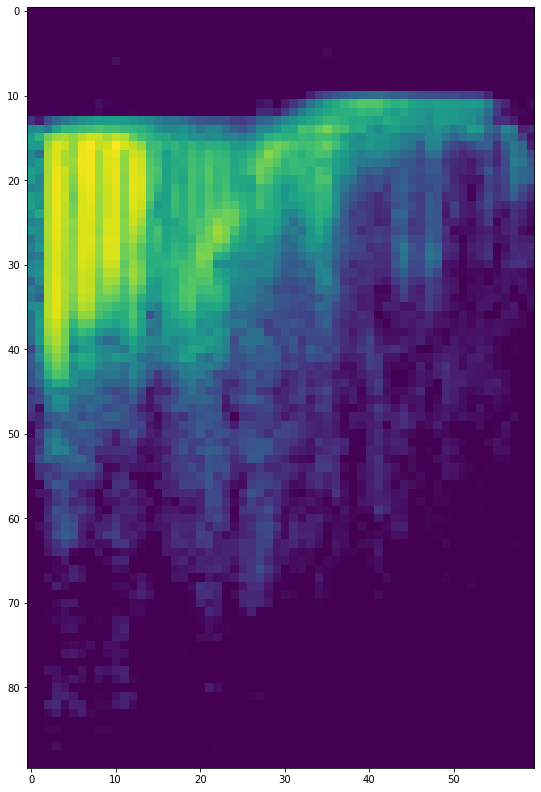

In [25]:


samplingRate = 16000
sample_len = 16384      # padded length of one sample

frame_len = 512
window_stride = 184

melYsize = 60

melMatrix = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=melYsize,
            num_spectrogram_bins= frame_len // 2 + 1,
            sample_rate=samplingRate,
            lower_edge_hertz=0,
            upper_edge_hertz=samplingRate // 2)



@tf.function(jit_compile=False)
def _tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator



@tf.function(jit_compile=False)
def power_to_db(magnitude, amin=1e-16, top_db=80.0):
    ref_value = tf.reduce_max(magnitude)
    log_spec = 10.0 * _tf_log10(tf.maximum(amin, magnitude))
    log_spec -= 10.0 * _tf_log10(tf.maximum(amin, ref_value))
    log_spec = tf.maximum(log_spec, tf.reduce_max(log_spec) - top_db)

    return log_spec



@tf.function(jit_compile=False)
def fill_to_1sec(samples : tf.Tensor):
    """
    For longer audio: randomly crops
    For shorter audio: adds silence at the beginning
    """
    
    @tf.function(jit_compile=False)
    def gt(s : tf.Tensor, leng, L):     # greater than - crops
        i = tf.random.uniform([], minval=0, maxval=tf.math.abs(L - leng), dtype=tf.int32)
        return s[i:(i+L)]
        
    @tf.function(jit_compile=False)      # less than
    def lt(s : tf.Tensor, leng, L):
        rem_len = tf.math.abs(L - leng)
        return tf.pad(s, [[rem_len, 0]], "CONSTANT")

    sample_len = 16384
    real_sample_len = tf.shape(samples)[0]
    
    tmp = tf.cond(tf.less(sample_len, real_sample_len), lambda: gt(samples, real_sample_len, sample_len), lambda: samples)
    tmp2 = tf.cond(tf.less(real_sample_len, sample_len), lambda: lt(tmp, real_sample_len, sample_len), lambda: tmp)
    
        
    return tmp2    





@tf.function(jit_compile=False, experimental_follow_type_hints=True)
def load_wav_file(filename) -> tf.Tensor:
    
    soundfile = tf.io.read_file(projDir + filename)
    sample, _ = tf.audio.decode_wav(soundfile)
    
    #sample = tfio.audio.decode_flac(soundfile)
    


    sample = tf.squeeze(sample, axis=[-1])            # remove last dim
    
    sample = tf.cast(sample, tf.float32) / np.iinfo(np.int16).max       # convert to (-1, 1) float32
    sample = fill_to_1sec(sample)  #make sure segment is 1 second long
        
    return sample





@tf.function(jit_compile=False, input_signature=[tf.TensorSpec(shape=(sample_len, ), dtype=tf.float32)])
def process_wav_file(sample : tf.Tensor) -> tf.Tensor:
    """
    Computes time-freq spectrogram
    Input - audio wave
    Output - real matrix
    """
    
    spec = tf.signal.stft(sample, frame_length=frame_len, frame_step=window_stride, window_fn=tf.signal.hann_window, pad_end=True) 
    spec = tf.square(tf.abs(spec))
    
    spec = tf.matmul(spec, melMatrix) 
            
    spec = (power_to_db(spec) / 80.0) + 1.0  
    
    return spec       





### Show result
d = load_wav_file(all_files[randint(0, len(all_files)-1)])
d = process_wav_file(d)
print("Spectrogram shape:", d.shape)
#tf.print(d)

fig = plt.figure(figsize=(32, 14))
imgplot = plt.imshow(d)


In [ ]:

def prepare_dataset(data_df, dataset_size=-1):
    
    dataset_chunk = data_df.sample(frac=1).reset_index(drop=True).iloc[0:dataset_size]
    
    X_data = tf.data.Dataset.from_tensor_slices(dataset_chunk.wav_file)
    X_data = (
        X_data.map(load_wav_file, num_parallel_calls=tf.data.AUTOTUNE)
              .map(process_wav_file, num_parallel_calls=tf.data.AUTOTUNE)
    )
    

    Y_data = to_categorical(dataset_chunk.label_id, num_classes = len(POSSIBLE_LABELS)) #* 0.9 + 0.05    # label smoothing, 0.05 and 0.95
    Y_data = tf.data.Dataset.from_tensor_slices(Y_data)

    return tf.data.Dataset.zip((X_data, Y_data))

    
    
with tf.device("/device:CPU:0"):
    
    tf_dataset = prepare_dataset(train_df, -1).cache("train_dataset.cache").shuffle(2048)  
    tf_dataset_val = prepare_dataset(valid_df, -1).cache("val_dataset.cache").shuffle(512)
    tf_dataset_test = prepare_dataset(valid_df, -1).cache("test_dataset.cache").shuffle(512)

     
    
    
BS = 16
data_iter = iter(tf_dataset_val.batch(BS))



samples_to_save = 7050 - 7050 % BS




specs, results = next(data_iter)

specs = tf.cast(specs * 255, tf.uint8)

print(specs.dtype)


for i in range(samples_to_save // BS - 1):
    spec, result = next(data_iter)
    
    spec = tf.cast(spec * 255, tf.uint8)
    
    specs = tf.concat([specs, spec], axis=0)
    results = tf.concat([results, result], axis=0)
    

    
    print(i * BS, spec.shape)
    
    
print(specs.shape)
    
print("done")







#data_iter = iter(tf_dataset.repeat().batch(1))





# Try generate a batch
#d = next(data_iter)
#print("Spectrogram shape:", d[0].shape)

#fig = plt.figure(figsize=(32, 14))
#imgplot = plt.imshow(np.transpose(d[0]).astype(dtype="float32"))

#gc.collect()



In [34]:
np.save("specs_val.npy", specs.numpy())
np.save("results_val.npy", results.numpy())

In [60]:
#load dataset


trainX = np.load("specs_train.npy")
trainY = np.load("results_train.npy")
trainX = tf.convert_to_tensor(trainX, dtype=tf.float32) / 255.0

valX = np.load("specs_val.npy")
valY = np.load("results_val.npy")
valX = tf.convert_to_tensor(valX, dtype=tf.float32) / 255.0

print('There are {} train and {} validation (including background noise)'.format(trainX.shape[0], valX.shape[0]))



There are 52736 train and 7040 validation (including background noise)


In [50]:
#np.bincount(valY)


print(valY.shape, np.sum(valY, axis=0))



(7040, 11) [ 261.  270.  260.  264.  247.  255.  257.  256.  246.  258. 4466.]


Spectrogram shape: (1, 90, 257)
Spectrogram shape: tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(1, 11), dtype=float32)
Spectrogram shape: (1, 90, 60)


6387

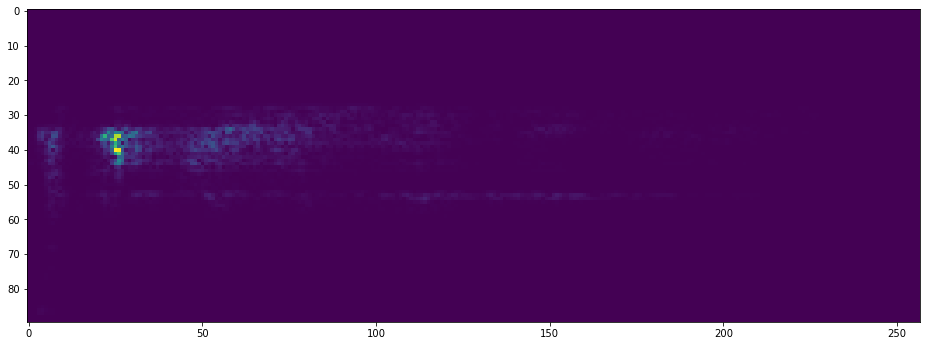

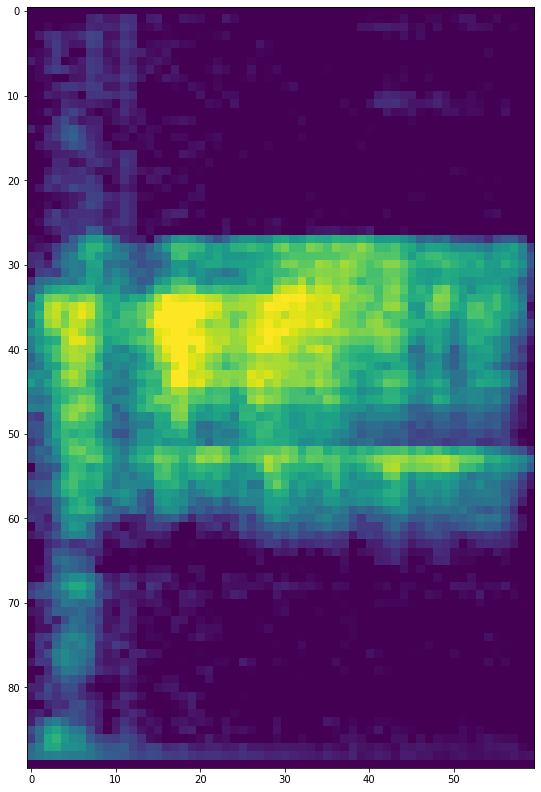

In [195]:

d = next(data_iter)


print("Spectrogram shape:", d[0].shape)
print("Spectrogram shape:", d[1])


fig = plt.figure(figsize=(16, 7))
imgplot = plt.imshow(d[0][0])



x = MEL_scale(melYsize=60, frame_len=frame_len, samplingRate=samplingRate)(d[0])
x = Convert_dB_Norm()(x)
x = AugmentAmplitude(mean_aug=0.1, percent_aug=0.2)(x) 
x = RandomNoise(0.05)(x)
x = ClampLayer(lower_bound=0.0, upper_bound=1.0)(x)

print("Spectrogram shape:", x.shape)

fig = plt.figure(figsize=(32, 14))
imgplot = plt.imshow(x[0])


gc.collect()

In [61]:
from keras.callbacks import TensorBoard
exp_name = "test_rfgjkjd"


callbacks = [TerminateOnNaN()]



In [122]:
# Architecture

with tf.device(DEVICE):

    K.clear_session()   
    


    class TransformerBlock(Layer):
        def __init__(self, embed_dim, num_heads, ff_dim, rate=0.05):
            super(TransformerBlock, self).__init__()

            self.num_heads = num_heads
            self.embed_dim = embed_dim
            self.ff_dim = ff_dim
            self.dropout_rate = rate

            self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, 
                                          kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))
            self.ffn = Sequential(
                [Dense(ff_dim, activation="ReLU", kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),        # LeakyReLU
                 Dense(embed_dim, kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0)),]
            )
            self.layernorm1 = LayerNormalization(epsilon=1e-6)
            self.layernorm2 = LayerNormalization(epsilon=1e-6)
            self.dropout1 = Dropout(rate)
            self.dropout2 = Dropout(rate)

        @tf.function(jit_compile=False, experimental_follow_type_hints=True)
        def call(self, inputs, training=True):
            attn_output = self.att(inputs, inputs)
            attn_output = self.dropout1(attn_output, training=training)
            out1 = self.layernorm1(inputs + attn_output) # layernorm
            ffn_output = self.ffn(out1)
            ffn_output = self.dropout2(ffn_output, training=training)
            return self.layernorm2(out1 + ffn_output)       # layernorm2


        def get_config(self):
            cfg = super(TransformerBlock, self).get_config()
            cfg.update({'num_heads': self.num_heads,
                        'embed_dim': self.embed_dim,
                        'ff_dim': self.ff_dim,
                          'dropout_rate': self.dropout_rate})
            return cfg



    
    
    class RandomMask(Layer):
        def __init__(self, maxLen=64, masked_rate=0.75):
            super(RandomMask, self).__init__()

            self.maskedRate = masked_rate
            self.maxLen = maxLen
            self.trainable = False
 
        @tf.function(jit_compile=False)
        def call(self, inputs, training=None):
            
            batch_size = tf.shape(inputs)[-3]   # or 0 ?
            mask = tf.random.uniform(shape=(batch_size, self.maxLen,), minval=0.0, maxval=1.0, dtype=tf.float32)      # stateless_uniform
            mask = tf.cast(tf.math.greater(mask, self.maskedRate), dtype=tf.float32) 
            
            mask = tf.expand_dims(mask, axis=-1)
            mask = tf.tile(mask, multiples=(1, 1, tf.shape(inputs)[-1]))        # expand the last dimension
            
            #if training: 
            return tf.math.multiply(inputs, mask), mask
            
            #return inputs, tf.ones(tf.shape(inputs))        # ones = no mask


        def get_config(self):
            cfg = super(RandomMask, self).get_config()
            cfg.update({'maskedRate': self.maskedRate,
                        'maxLen': self.maxLen})
            return cfg
        
    
    class RestoreUnmaskedTokens(Layer):
        def __init__(self, maxLen=64):
            super(RestoreUnmaskedTokens, self).__init__()

            self.maxLen = maxLen
            self.trainable = False

        @tf.function(jit_compile=False)
        def call(self, inputs, training=None):
            
            reconstructed, original, mask = inputs
            
            rec = tf.math.multiply(reconstructed, 1.0 - mask)
            remain = tf.math.multiply(original, mask)
            
            #if training: 
            return rec + remain
            
            #return reconstructed


        def get_config(self):
            cfg = super(RestoreUnmaskedTokens, self).get_config()
            cfg.update({'maxLen': self.maxLen})
            return cfg
        
        


    


    class PositionEmbedding(Layer):
        def __init__(self, maxlen, embed_dim):
            super(PositionEmbedding, self).__init__()
            self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)
            self.maxlen = maxlen

        @tf.function(jit_compile=False)
        def call(self, x):
            #maxlen = tf.shape(x)[-1]
            positions = tf.range(start=0, limit=self.maxlen, delta=1)
            positions = self.pos_emb(positions)
            return x + positions

        def get_config(self):
            cfg = super(PositionEmbedding, self).get_config()
            cfg.update({'pos_emb': self.pos_emb,
                        'maxlen': self.maxlen})
            return cfg

    
    
    
    
    class RandomNoise(Layer):
        def __init__(self, max_amp=0.1):
            super(RandomNoise, self).__init__()
            self.max_amp = max_amp
            self.trainable = False
            

        @tf.function(jit_compile=False)
        def call(self, x, training=None):
            inp_shape = tf.shape(x)
            batch_size = inp_shape[0]
            
            if not training:
                return x
            
            amp = tf.random.uniform([batch_size], minval=0.0, maxval=1.0, dtype=tf.float32) * self.max_amp  
            noise = tf.random.normal(shape=inp_shape, mean=0.0, stddev=1.0, dtype=tf.float32)
            
            amp = tf.reshape(amp, shape=[batch_size, 1, 1])
            amp = tf.tile(amp, multiples=(1, inp_shape[-2], inp_shape[-1]))        # expand the last dimension
            
            return x + noise * amp


        def get_config(self):
            cfg = super(RandomNoise, self).get_config()
            cfg.update({'max_amp': self.max_amp})
            return cfg



    
    class AugmentAmplitude(Layer):
        def __init__(self, mean_aug=0.1, percent_aug=0.1):
            super(AugmentAmplitude, self).__init__()
            self.mean_aug = mean_aug
            self.percent_aug = percent_aug
            self.trainable = False

        @tf.function(jit_compile=False)
        def call(self, x, training=None):

            inp_shape = tf.shape(x)
            batch_size = inp_shape[0]
            
            if not training:
                return x
            
            mean_shift = tf.random.uniform([batch_size], minval=-1.0, maxval=1.0, dtype=tf.float32) * self.mean_aug    
            # for mean_aug=0.1   -   (-0.1, 0.1)
            
            relative_change = tf.random.uniform([batch_size], minval=1.0-self.percent_aug, maxval=1.0+self.percent_aug, dtype=tf.float32)  
            # for 0.1 relative augmentation, get random on (0.9, 1.1)

    
            relative_change = tf.reshape(relative_change, shape=[batch_size, 1, 1])
            mean_shift = tf.reshape(mean_shift, shape=[batch_size, 1, 1])
            
            relative_change = tf.tile(relative_change, multiples=(1, inp_shape[-2], inp_shape[-1]))        # expand the last dimension
            mean_shift = tf.tile(mean_shift, multiples=(1, inp_shape[-2], inp_shape[-1])) 
            
            
            return x * relative_change + mean_shift 


        def get_config(self):
            cfg = super(AugmentAmplitude, self).get_config()
            cfg.update({'mean_aug': self.mean_aug, 
                        'percent_aug': self.percent_aug})
            return cfg
        
        
    




    class MEL_scale(Layer):
        def __init__(self, melYsize=128, frame_len=2048, samplingRate=16000):
            super(MEL_scale, self).__init__()
            self.melYsize = melYsize
            self.frame_len = frame_len
            self.samplingRate = samplingRate
            self.trainable = False
            
        def build(self, input_shape):
            self.melMatrix = tf.signal.linear_to_mel_weight_matrix(
                            num_mel_bins=self.melYsize,
                            num_spectrogram_bins=self.frame_len // 2 + 1,
                            sample_rate=self.samplingRate,
                            lower_edge_hertz=0,
                            upper_edge_hertz=self.samplingRate // 2)


        @tf.function(jit_compile=False)
        def call(self, x : tf.Tensor) -> tf.Tensor:

            return tf.matmul(tf.square(x), self.melMatrix)
        

        def get_config(self):
            cfg = super(MEL_scale, self).get_config()
            cfg.update({'melYsize': self.melYsize, 
                        'frame_len': self.frame_len,
                        'samplingRate': self.samplingRate})
            return cfg
        
        
        
    class Convert_dB_Norm(Layer):
        def __init__(self):
            super(Convert_dB_Norm, self).__init__()
            self.trainable = False

        @tf.function(jit_compile=False)
        def call(self, x : tf.Tensor) -> tf.Tensor:
            return (power_to_db(x) / 80.0) + 1.0
        

        
    class ClampLayer(Layer):
        def __init__(self, lower_bound=0.0, upper_bound=1.0):
            super(ClampLayer, self).__init__()
            self.lower = lower_bound
            self.upper = upper_bound
            self.trainable = False


        @tf.function(jit_compile=False)
        def call(self, x : tf.Tensor) -> tf.Tensor:
            return tf.clip_by_value(x, self.lower, self.upper)
        

        def get_config(self):
            cfg = super(ClampLayer, self).get_config()
            cfg.update({'lower': self.lower, 
                        'upper': self.upper})
            return cfg
        
        

    
    class InvertedResidual(Layer):
        def __init__(self, filters, strides, expansion_factor=6, trainable=True,
                    name=None, **kwargs):
            super(InvertedResidual, self).__init__(trainable=trainable, name=name, **kwargs)
            self.filters = filters
            self.strides = strides
            self.expansion_factor = expansion_factor	# allowed to be decimal value
            self.activation = tf.nn.relu

        def build(self, input_shape):
            input_channels = int(input_shape[3])
            self.ptwise_conv1 = Conv2D(filters=int(input_channels*self.expansion_factor), kernel_size=1, use_bias=True, 
                                        kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))
            self.dwise = DepthwiseConv2D(kernel_size=3, strides=self.strides, padding='same', use_bias=True, 
                                         kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))
            self.ptwise_conv2 = Conv2D(filters=self.filters, kernel_size=1, use_bias=True, 
                                       kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))

            self.bn1 = BatchNormalization()
            self.bn2 = BatchNormalization()
            self.bn3 = BatchNormalization()

        def call(self, input_x):
            # Expansion to high-dimensional space
            x = self.ptwise_conv1(input_x)
            x = self.bn1(x)
            x = self.activation(x)

            # Spatial filtering
            x = self.dwise(x)
            x = self.bn2(x)
            x = self.activation(x)

            # Projection back to low-dimensional space w/ linear activation
            x = self.ptwise_conv2(x)
            x = self.bn3(x)

            # Residual connection if i/o have same spatial and depth dims
            if input_x.shape[1:] == x.shape[1:]:
                x += input_x
            return x

        def get_config(self):
            cfg = super(InvertedResidual, self).get_config()
            cfg.update({'filters': self.filters,
                        'strides': self.strides,
                        'expansion_factor': self.expansion_factor})
            return cfg



    
    class ResidualBlock(Layer):
        def __init__(self, filters, trainable=True,
                    name=None, **kwargs):
            super(ResidualBlock, self).__init__(trainable=trainable, name=name, **kwargs)
            self.filters = filters
            self.activation = tf.nn.relu

        def build(self, input_shape):

            self.conv1 = Conv2D(filters=self.filters, kernel_size=3, padding="same", kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))
            self.conv2 = Conv2D(filters=self.filters, kernel_size=3, padding="same", kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))

            self.norm1 = BatchNormalization()
            self.norm2 = BatchNormalization()

        @tf.function(jit_compile=False)
        def call(self, input_x):

            x = self.conv1(input_x)
            x = self.norm1(x)
            x = self.activation(x)

            x = self.conv2(x)
            x = self.norm2(x)

            # Residual connection if we have same spatial and depth dims
            if input_x.shape[1:] == x.shape[1:]:
                x += input_x

            return self.activation(x)

        def get_config(self):
            cfg = super(ResidualBlock, self).get_config()
            cfg.update({'filters': self.filters})
            return cfg



    
    class SimilarityLoss(keras.losses.Loss):
        def __init__(self):

            super(SimilarityLoss, self).__init__()
            self.lambda_amt = 5e-3
            

        def get_off_diag(self, c: tf.Tensor) -> tf.Tensor:
            zero_diag = tf.zeros(c.shape[-1])
            return tf.linalg.set_diag(c, zero_diag)


        def cross_corr_matrix_loss(self, c: tf.Tensor) -> tf.Tensor:
            
            c_diff = tf.pow(tf.linalg.diag_part(c) - 1, 2)      # subtracts diagonals by one and squares them - variance loss   
            off_diag = tf.pow(self.get_off_diag(c), 2) * self.lambda_amt    # takes off diagonal, squares it, multiplies with lambda - covariance loss

            return tf.reduce_sum(c_diff) + tf.reduce_sum(off_diag)        # sum first and second parts together
        

        def normalize(self, output: tf.Tensor) -> tf.Tensor:
            return (output - tf.reduce_mean(output, axis=0)) / tf.math.reduce_std(output, axis=0)
        

        def cross_corr_matrix(self, z_a_norm: tf.Tensor, z_b_norm: tf.Tensor) -> tf.Tensor:
            return (tf.transpose(z_a_norm) @ z_b_norm) / tf.cast(tf.shape(z_a_norm )[0], dtype=tf.float32)               #  self.batch_size

            

        def call(self, z_a: tf.Tensor, z_b: tf.Tensor) -> tf.Tensor:
            z_a_norm, z_b_norm = self.normalize(z_a), self.normalize(z_b)
            c = self.cross_corr_matrix(z_a_norm, z_b_norm)

            return self.cross_corr_matrix_loss(c)
        






In [123]:

################################ encoder - masked



timesteps = 90
mel_bins = 60
embed_dim = 32



inp = Input(shape=[timesteps, mel_bins])      # Input = right from STFT

x = inp

x = AugmentAmplitude(mean_aug=0.05, percent_aug=0.05)(x) 
x = RandomNoise(0.05)(x)
x = ClampLayer(lower_bound=0.0, upper_bound=1.0)(x)



x, mask = RandomMask(maxLen=timesteps, masked_rate=0.50)(x)

x = Dense(128, activation = 'ReLU', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = Dense(64, activation = 'ReLU', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = PositionEmbedding(timesteps, 64)(x)
x = Dense(embed_dim, activation = 'ReLU', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)


# Encoder
x = TransformerBlock(embed_dim, 3, embed_dim*2, rate=0.0)(x)
x = TransformerBlock(embed_dim, 3, embed_dim*2, rate=0.0)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.0)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.0)(x)

x = Dense(64, activation = 'sigmoid', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)

x = GlobalAveragePooling1D()(x)

x = Dense(64, activation = 'linear', name='targets')(x)

outp = x






encoder_mask = Model(inp, outp, name="encoder_mask")
opt = LAMB(learning_rate=0.001)


encoder_mask.build(input_shape=[timesteps, mel_bins])
encoder_mask.summary()

gc.collect()


#model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
#tf.keras.utils.plot_model(model, to_file="CNN.png", show_shapes=True)


Model: "encoder_mask"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 60)]          0         
                                                                 
 augment_amplitude (AugmentA  (None, 90, 60)           0         
 mplitude)                                                       
                                                                 
 random_noise (RandomNoise)  (None, 90, 60)            0         
                                                                 
 clamp_layer (ClampLayer)    (None, 90, 60)            0         
                                                                 
 random_mask (RandomMask)    ((None, 90, 60),          0         
                              (None, 90, 60))                    
                                                                 
 dense (Dense)               (None, 90, 128)          

36976

In [124]:

################################ encoder - no mask



timesteps = 90
mel_bins = 60
embed_dim = 32



inp = Input(shape=[timesteps, mel_bins])    

x = inp

x = AugmentAmplitude(mean_aug=0.05, percent_aug=0.05)(x) 
x = RandomNoise(0.05)(x)
x = ClampLayer(lower_bound=0.0, upper_bound=1.0)(x)


x = Dense(128, activation = 'ReLU', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = Dense(64, activation = 'ReLU', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)
x = PositionEmbedding(timesteps, 64)(x)
x = Dense(embed_dim, activation = 'ReLU', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)


# Encoder
x = TransformerBlock(embed_dim, 3, embed_dim*2, rate=0.0)(x)
x = TransformerBlock(embed_dim, 3, embed_dim*2, rate=0.0)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.0)(x)
x = TransformerBlock(embed_dim, 4, embed_dim*2, rate=0.0)(x)

x = Dense(64, activation = 'sigmoid', kernel_constraint=max_norm(10.0), bias_constraint=max_norm(10.0))(x)

x = GlobalAveragePooling1D()(x)

x = Dense(64, activation = 'linear', name='targets')(x)

outp = x







encoder_full = Model(inp, outp, name="encoder_full")
opt = LAMB(learning_rate=0.001)


encoder_full.build(input_shape=[timesteps, mel_bins])
encoder_full.summary()



gc.collect()


Model: "encoder_full"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 90, 60)]          0         
                                                                 
 augment_amplitude_1 (Augmen  (None, 90, 60)           0         
 tAmplitude)                                                     
                                                                 
 random_noise_1 (RandomNoise  (None, 90, 60)           0         
 )                                                               
                                                                 
 clamp_layer_1 (ClampLayer)  (None, 90, 60)            0         
                                                                 
 dense_12 (Dense)            (None, 90, 128)           7808      
                                                                 
 dense_13 (Dense)            (None, 90, 64)           

1350

In [11]:
################################# AE



#x = InvertedResidual(64, (1, 1), expansion_factor=6)(x)
#kernel_constraint=max_norm(2.0)
#x = Conv2DTranspose(32, kernel_size=(3, inp_dim), strides=(2, 1), activation="LeakyReLU", kernel_regularizer=l1(l1_reg), bias_regularizer=l1(l1_reg), padding="SAME")(x)
#x = Conv2D(32, (3, inp_dim), activation="LeakyReLU", kernel_regularizer=l1(l1_reg), bias_regularizer=l1(l1_reg), padding="same")(x)
#x = Conv2DTranspose(1, kernel_size=1, strides=1, activation="linear", padding="SAME", dtype='float32')(x)
#x = DepthwiseConv2D(kernel_size=5, strides=2, activation="ReLU", padding='same')(x)
#x = Cropping1D([0, predict_len])(x)
#x = GlobalAveragePooling1D()(x)
# Dense(32, activation = 'LeakyReLU', kernel_regularizer=l2(0.01))
# Reshape([64, 129])
# Conv1D(32, 9, activation='relu', input_shape=[129])
# Dropout(p)
# BatchNormalization()
# Permute((2, 1), input_shape=(64, 129))
# LSTM(64, return_sequences = True)
# Flatten()
# GRU(64, return_sequences = True)
# Concatenate(axis=1)([x, y]) 
# Reshape([-1, 128])(inp)
#x = Rescaling(scale=1.0/255.0)(x)
#outp = tf.cast(x, tf.dtypes.float16) # Rescaling(scale=255.0)(x)
#x = GaussianNoise(0.2)(x)
#x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
#outp = Dense(len(POSSIBLE_LABELS), activation="softmax")(x)
#x = PositionEmbedding(timesteps, embed_dim)(x)
#x = RandomMask(maxLen=timesteps, masked_rate=0.3)(x)
#x = RestoreUnmaskedTokens()([x, mask_input, mask])
#x = RepeatVector(28, input_shape=[30])(x)  # 28x vector
#x = TimeDistributed(Dense(28, activation="sigmoid"))(x)
#x = ActivityRegularization(l1=1e-3)(x)
#x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="selu")


#print(x.shape)


"""
for l in model.layers:
    print(lay.name, lay.output_shape)
"""

'\nfor l in model.layers:\n    print(lay.name, lay.output_shape)\n'

In [125]:

class AEModel(keras.Model):

    def __init__(self, encoder, encoder_patched):
        super(AEModel, self).__init__()
        self.encoder = encoder
        self.encoder_patched = encoder_patched


    
    @tf.function(jit_compile=False)
    def call(self, inp):
        
        full_PA = inp
        
        return self.encoder(full_PA, training=False)         
    
    
    

    @tf.function(jit_compile=False)
    def train_step(self, batch):

        spectrogram, _ = batch 
        
        with tf.GradientTape() as tape:
            reconstructed_full = self.encoder(spectrogram, training=True)
            reconstructed_masked = self.encoder_patched(spectrogram, training=True)
            
            loss = self.compiled_loss(reconstructed_full, reconstructed_masked)   		#self.loss(result, pred), regularization_losses=self.losses   



        learnable_params = (self.encoder.trainable_variables 
                            + self.encoder_patched.trainable_variables)

        grads_model = tape.gradient(loss, learnable_params)
        self.optimizer.apply_gradients(zip(grads_model, learnable_params))
        

        self.compiled_metrics.update_state(reconstructed_full, reconstructed_masked)
        return {m.name: m.result() for m in self.metrics}
		






model = AEModel(encoder_full, encoder_mask)


model.compile(optimizer=opt, loss=SimilarityLoss())   
model.build(input_shape=[None, timesteps, mel_bins])


model.summary()


Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_full (Functional)   (None, 64)                106272    
                                                                 
 encoder_mask (Functional)   (None, 64)                106272    
                                                                 
Total params: 212,544
Trainable params: 212,544
Non-trainable params: 0
_________________________________________________________________


In [128]:
# train
gc.collect()

K.set_value(model.optimizer.learning_rate, 0.001)
batch_size = 32







try:
    cur_dataset = tf_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    cur_val_dataset = tf_dataset_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    hist = model.fit(x=trainX[:512], y=trainX[:512], callbacks=callbacks,
                     batch_size = batch_size, epochs = 100)  # 
    
    #hist = SAM_model.fit(cur_dataset, validation_data=cur_val_dataset, callbacks=callbacks, class_weight=class_weights,
    #                 batch_size = batch_size, epochs = 100)  # 
    
    
    model.save_weights(exp_name)
    
    fig = plt.figure(figsize=(10, 5))
    plt.plot(hist.history["loss"], color="blue")
    plt.plot(hist.history["val_loss"], color="red")
    plt.title("Loss curve")
    plt.legend(["Training loss", "Validation loss"])
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.savefig("loss.png") # eps 
    
    #plt.show()
except KeyboardInterrupt:
    print("Interrupted")





#AE.fit(X, X, callbacks=callbacks, validation_data=(valX, valX), batch_size = 512, epochs = 100, shuffle=True)  #   validation_data=(valX, valY)
#model.fit(training_generator, callbacks=callbacks, validation_data=validation_generator, batch_size = batch_size, epochs = 7, use_multiprocessing = True, workers = 2)  # initial_epoch = 5


#model.save_weights(projDir + 'weights/test_2.hdf5')
#model.save(projDir + 'models/' + exp_name)

Epoch 1/100
16/16 [==============================] - 29s 2s/step - loss: 6.0555
Epoch 2/100
16/16 [==============================] - 29s 2s/step - loss: 5.7077
Epoch 3/100
16/16 [==============================] - 28s 2s/step - loss: 5.2015
Epoch 4/100
16/16 [==============================] - 28s 2s/step - loss: 4.9896
Epoch 5/100
16/16 [==============================] - 27s 2s/step - loss: 5.0620
Epoch 6/100
16/16 [==============================] - 27s 2s/step - loss: 5.0962
Epoch 7/100
16/16 [==============================] - 28s 2s/step - loss: 4.8249
Epoch 8/100
16/16 [==============================] - 29s 2s/step - loss: 4.5947
Epoch 9/100
16/16 [==============================] - 28s 2s/step - loss: 4.4116
Epoch 10/100
16/16 [==============================] - 28s 2s/step - loss: 4.3497
Epoch 11/100
16/16 [==============================] - 27s 2s/step - loss: 4.2519
Epoch 12/100
16/16 [==============================] - 27s 2s/step - loss: 4.3082
Epoch 13/100
16/16 [=================

In [259]:


model.load_weights("teeeest")
#model.save_weights("teeeest")

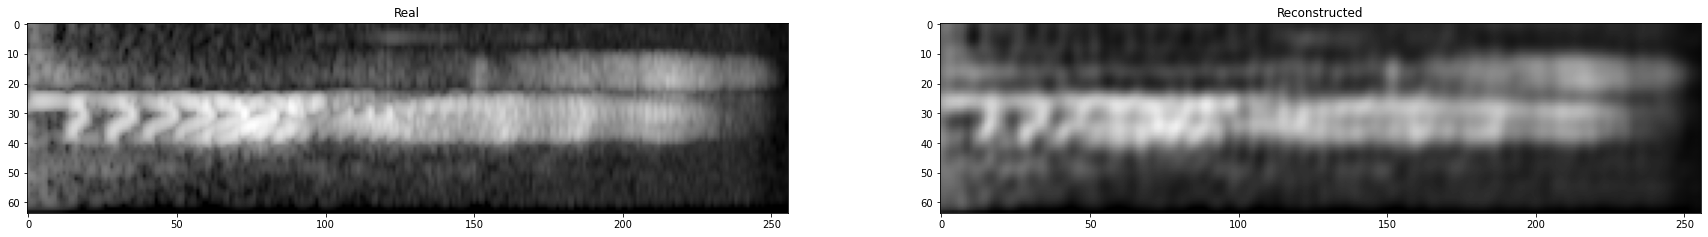

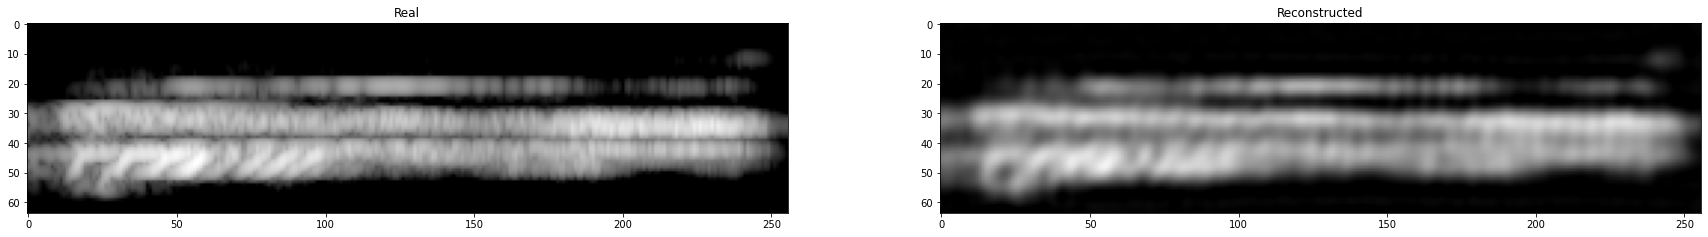

In [ ]:




# Evaluate autoencoder

N_show = 2
#random_index = randint(0, len(valX)-N_show)
#tmps = valX[random_index:random_index+N_show]


data_iter = iter(X_data.batch(2).repeat())

tmps = next(data_iter)
tmp2 = test_m.predict(tmps)


for i, mel in enumerate(tmps):
    
  fig = plt.figure(figsize=(30, 9))
  ax = fig.add_subplot(N_show, 2, i*2 + 1)
 

  imgplot = plt.imshow(mel, cmap='gray', vmin=0.0, vmax=1.0)
  ax.set_title('Real')

  ax = fig.add_subplot(N_show, 2, i*2 + 2)
  imgplot = plt.imshow(tmp2[i], cmap='gray', vmin=0.0, vmax=1.0)
  #imgplot.set_clim(0.0, 0.7)
  ax.set_title('Reconstructed')







encoded = encoder.predict(tmps)[0]


#val 317, 102 clean



In [ ]:
# Show layers output

"""

"""

layer_num = 2
enc = True





if enc:
    mdl = encoder
    inp = next(data_iter)[0]
else:
    mdl = decoder
    inp = encoded
       
layer_outputs = [layer.output for layer in mdl.layers[:]] 
generate = True
if generate:
    for i, l in enumerate(mdl.layers):
        print(i, l.name, l.output_shape)

    get_activations = Model(inputs=mdl.input, outputs=layer_outputs)
    activations = get_activations.predict(np.expand_dims(inp, axis=0))


print(activations[layer_num][0].shape)

x = activations[layer_num][0]
x = np.transpose(x, (2, 0, 1))
#print(x.shape)

print("Min, max: ", np.min(x), np.max(x))
#print("AE: ", x[0, :24, :24])





aspect_ratio = x.shape[1] / x.shape[2]  # 2.0 -> vyska = 2 * sirka
channel_count = x.shape[0]

x_count = 6 # charts per row
y_count = channel_count // x_count + 1



fig = plt.figure(figsize=(24, int(24 * aspect_ratio * y_count / x_count)))

for i, xr in enumerate(x):

    fig.add_subplot(y_count, x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')

print("Done")








NameError: name 'encoder' is not defined

In [ ]:
# Show output interval

print("### ENCODER ###")
   
layer_outputs = [layer.output for layer in model.layers[:]] 

generate = True
if generate:
    get_activations = Model(inputs=model.input, outputs=layer_outputs)
    activations = get_activations.predict(np.expand_dims(next(data_iter)[0][0], axis=0))
    
print("         Min      Max       SqrtVar   ")
for i, l in enumerate(model.layers):
        print("Layer", i, l.name, l.output_shape)
        print("  ", np.min(activations[i][0]), np.max(activations[i][0]), np.sqrt(np.var(activations[i][0])), '\n')










### ENCODER ###
         Min      Max       SqrtVar   
Layer 0 input_2 [(None, 32, 128)]
   -1.4901161e-08 1.0 0.17397629 

Layer 1 gru_1 (None, 64)
   -0.8016856 0.8713495 0.43068796 

Layer 2 dense_1 (None, 64)
   -0.926757 0.91028786 0.55776656 

Layer 3 targets (None, 30)
   0.001242202 0.36259094 0.073918976 



In [ ]:
## show kernels


mdl = encoder
inp = X[0]   #encoded
layer_weights = [layer.weights for layer in mdl.layers[:]] 

generate = True
if generate:
    #for i, l in enumerate(mdl.layers):
    #    print(i, l.name, l.output_shape)

    get_weights_model = Model(inputs=mdl.input, outputs=layer_weights)
    weights = get_weights_model.predict(np.expand_dims(inp, axis=0))

layer_num = 4

weights = layer_weights[2]
print(weights)



#print(weights[layer_num].shape)

x = np.array(weights)[0]
x = np.transpose(x, (2, 0, 1, 3))[0]
x = np.transpose(x, (2, 1, 0))   # transpose



aspect_ratio = 64 / 64

x_count = 4
y_size = 32 / x_count


fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))

for i, xr in enumerate(x):
    fig.add_subplot(x.shape[0], x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')
    


print("Done")





In [ ]:
result = AE.predict(X[:2])[0]

difference = X[0]-result

print("AE: ", np.min(X[0]), np.max(X[0]))
print("AE: ", np.min(result), np.max(result))
print("Diff: ", np.min(difference), np.max(difference))

aspect_ratio = 256 / 64
y_size = 32

fig = plt.figure(figsize=(y_size * aspect_ratio, y_size))
plt.imshow(difference, cmap='gray')
plt.axis('off')

print("Done")


NameError: name 'AE' is not defined

Done


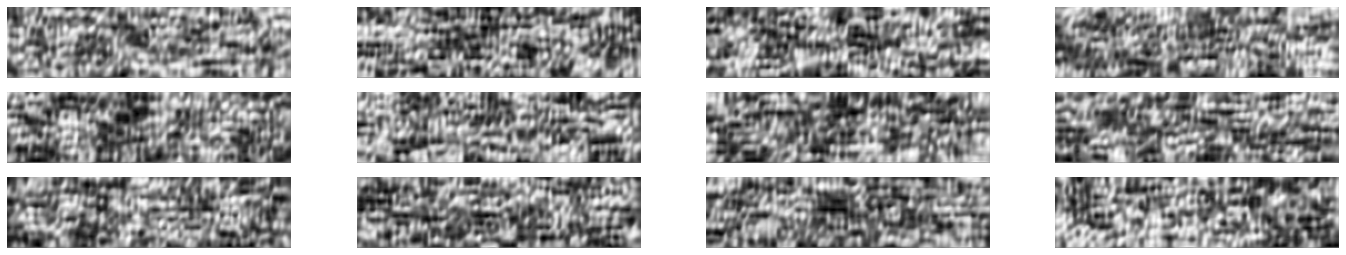

In [ ]:
# Sample decoder



N = 12
enc = tf.random.normal([N, 4, 256], dtype=tf.float16) * 1.0
x = trans_block2(enc)

#tf.print(x)

x = decoder(x)


aspect_ratio = x.shape[1] / x.shape[2]  # 2.0 -> vyska = 2 * sirka
channel_count = x.shape[0]

x_count = 4 # charts per row
y_count = channel_count // x_count + 1



fig = plt.figure(figsize=(24, int(24 * aspect_ratio * y_count / x_count)))

for i, xr in enumerate(x):

    fig.add_subplot(y_count, x_count, i+1)
    plt.imshow(xr, cmap='gray')
    plt.axis('off')

print("Done")








In [ ]:

class RandomMask2(Layer):
    def __init__(self, maxLen=64, masked_rate=0.75, blur_kernel = 3):
        super(RandomMask2, self).__init__()

        self.maskedRate = masked_rate
        self.maskLayer = Masking(mask_value=0.0)
        self.rnd = tf.random.get_global_generator()
        self.maxLen = maxLen
        self.blur_kernel = blur_kernel
        self.trainable = False
       

    def call(self, inputs):

        input_dims = [tf.shape(inputs)[-1], tf.shape(inputs)[-2]] # transposed
        mask = self.rnd.uniform(shape=(self.maxLen,), minval=0.0, maxval=1.0, dtype=tf.dtypes.float32)
        mask = tf.math.greater(mask, self.maskedRate)
        mask = tf.cast(mask, tf.dtypes.float32)
        
        mask = tf.transpose(tf.ones(input_dims) * mask)
        
        blured = tfa.image.mean_filter2d(inputs, filter_shape = (1, self.blur_kernel))

        return inputs * mask + blured * (1.0 - mask)


    def get_config(self):
        cfg = super(RandomMask2, self).get_config()
        cfg.update({'maskedRate': self.maskedRate,
                    'blur_kernel': self.blur_kernel,
        	        'maxLen': self.maxLen})
        return cfg




x = X[2]

#rand_mask = RandomMask2(256, 0.75, 1)

sPool = TempPoolingBlock(128, num_heads=36, ff_dim=1024)

x = tf.expand_dims(x, axis=0)

x = sPool(x)[0]



#loss_result = FFT_patch_loss(X[0:4], X[5:9])
#print(loss_result.shape)




fig = plt.figure(figsize=(12, 20))
plt.imshow(x, cmap='gray')
plt.axis('off')


NameError: name 'X' is not defined

In [ ]:
# Clear memory

err = 0.07          # losses  1.22 -> 1.17

for e in range(11):
    err = 0.01 * e
    print("Err-Loss: ", err, tf.math.log(1.0 + tf.abs(err)) * 100 )     
    
print("\n\n\n")

for e in range(11):
    err = 0.01 * e
    print("Err-Loss: ", err, tf.math.log(1.0 + 100 * tf.abs(err)) * 10 ) 
    
    # tf.math.reduce_mean(tf.math.log(1.0 + 100 * tf.abs(spec1-spec2))) * 10 


#loss = 4.59
#print("Error: ", tf.math.exp(loss / 100.0) - 1)

#del X, Y
#gc.collect()

# %debug          commands -     h

#model.load_weights(projDir + 'models/' + "working_CNN_AE")

#print(tmps[0])
#with open(projDir + 'data/train_X_hartley.npy', 'wb') as f:
#  np.save(f, X)

#with open(projDir + 'data/valid_X_hartley.npy', 'wb') as f:
#  np.save(f, valX)

In [ ]:
import pyaudio
import wave
import numpy as np

chunk = 1024  # Record in chunks of 1024 samples
sample_format = pyaudio.paInt16  # 16 bits per sample
channels = 1
fs = 44100  # Record at 44100 samples per second
seconds = 1
filename = "output.wav"

p = pyaudio.PyAudio()  # Create an interface to PortAudio

print('Recording')

stream = p.open(format=sample_format,
                channels=channels,
                rate=fs,
                frames_per_buffer=chunk,
                input=True)

frames = []  # Initialize array to store frames

# Store data in chunks for 3 seconds
for i in range(0, int(fs / chunk * seconds)):
    data = stream.read(chunk)
    np_data = np.frombuffer(data, dtype=np.int16)
    frames.append(data)

# Stop and close the stream 
stream.stop_stream()
stream.close()
# Terminate the PortAudio interface
p.terminate()

print('Finished recording')

# Save the recorded data as a WAV file
wf = wave.open(filename, 'wb')
wf.setnchannels(channels)
wf.setsampwidth(p.get_sample_size(sample_format))
wf.setframerate(fs)
wf.writeframes(b''.join(frames))
wf.close()

In [ ]:
# Generator class


class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'

    def __init__(self, filename, batch_size = 32, shuffle = True):
        'Initialization'

        self.batch_size = batch_size

        self.allX = np.load(projDir + "data/" + filename + "_X.npy")
        self.allY = np.load(projDir + "data/" + filename + "_Y.npy")

        self.size = self.allX.shape[0]

        self.indexes = np.arange(self.size)
        self.shuffle = shuffle
        self.on_epoch_end()



    def __len__(self):
        'Denotes the number of batches per epoch'

        return int(np.floor(self.size / self.batch_size))



    def __getitem__(self, index):
        'Generate one batch of data'

        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        return self.__data_generation(indexes)


    def on_epoch_end(self):
        'Updates indexes after each epoch'

        if self.shuffle == True:
            np.random.shuffle(self.indexes)



    def __data_generation(self, IDs):


        # Initialization
        #tmpX = np.diff(np.array(self.allX)[IDs], axis=-2, prepend=0) 

        tmpX = np.array(self.allX)[IDs]
        tmpY = np.array(self.allY)[IDs]

        #for ID in range(tmpX.shape[0]): 
        #  tmpX[ID] = augment_spectrogram_diff(tmpX[ID])
          # dalse augmentace


        return tmpX, tmpY


training_generator = DataGenerator("train", batch_size, shuffle=True)
validation_generator = DataGenerator("valid", batch_size, shuffle=False)

In [ ]:
# Load model


model = load_model(projDir + 'models/' + exp_name)
print('Loaded')

In [ ]:
# save model
exp_name = "64x256_4x16x16_AE"
test_m.save_weights(projDir + 'weights/' + exp_name + '.hdf5')
test_m.save(projDir + 'models/' + exp_name)

encoder.save_weights(projDir + 'weights/encoder_' + exp_name + '.hdf5')
encoder.save(projDir + 'models/encoder_' + exp_name)

decoder.save_weights(projDir + 'weights/decoder_' + exp_name + '.hdf5')
decoder.save(projDir + 'models/decoder_' + exp_name)

#styleLayer.save_weights(projDir + 'weights/styleLayer_' + exp_name + '.hdf5')
#styleLayer.save(projDir + 'models/styleLayer_' + exp_name)

#trans_block.save_weights(projDir + 'weights/trans_block_' + exp_name + '.hdf5')
#trans_block.save(projDir + 'models/trans_block_' + exp_name)

print('Saved')



INFO:tensorflow:Assets written to: models/64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/encoder_64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/encoder_64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/decoder_64x256_4x16x16_AE/assets


INFO:tensorflow:Assets written to: models/decoder_64x256_4x16x16_AE/assets


Saved


In [ ]:
# Evaluate random sample

random_index = randint(0, valid_df.shape[0])
fileName = valid_df.wav_file[random_index]

mel = np.transpose(process_wav_file(fileName))
mel = augment_spectrogram_diff(mel)


mel = np.array([mel.reshape(mel.shape[0],-1)]) # mel coefs
res = model.predict(mel)

print("Prediction: ", id2name[np.argmax(res, axis=1)[0]])   # print prediction
AudioSegment.from_wav(fileName) # play



In [ ]:
# Test

fileName = projDir + 'mySounds/go_1.wav'

mel = np.transpose(process_wav_file(fileName))

plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(mel), cmap='gray', vmin=0, vmax=80, aspect=0.25, interpolation = 'none', origin = 'lower')
plt.title('Mel power spectrogram ')
plt.xlabel('Time (s)')
plt.ylabel('Frekvence')
plt.show()


mel = augment_spectrogram_diff(mel)


plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(mel), cmap='gray', vmin=-26, vmax=26, aspect=0.25, interpolation = 'none', origin = 'lower')
plt.title('Mel power spectrogram ')
plt.xlabel('Time (s)')
plt.ylabel('Frekvence')
plt.show()


mel = np.array([mel.reshape(mel.shape[0],-1)]) # mel coefs
res = model.predict(mel)

print("Prediction: ", id2name[np.argmax(res, axis=1)[0]])   # print prediction
AudioSegment.from_wav(fileName) # play


In [ ]:
# Evaluate accuracy for each keyword

#[valX, valY] = load_data_from_bin("DataAll_valid_128_64")

correctGuess = np.zeros(len(POSSIBLE_LABELS))
mistakeIDs = []

results = model.predict(valX)


ids = np.argmax(results, axis=1)
correctIDs = np.argmax(valY, axis=1)


#print(np.bincount(ids))
#print(np.bincount(correctIDs))


for i in range(len(valY)):
  if ids[i] == correctIDs[i]:
    correctGuess[ids[i]] = correctGuess[ids[i]] + 1
  else:
    mistakeIDs.append([i, ids[i], correctIDs[i]])

#print(correctGuess)
    
correctGuess = np.divide(correctGuess, np.bincount(correctIDs, minlength = len(POSSIBLE_LABELS)))



#correctGuess[30] = 0.0  # unknown zatim neni ve validation setu

print("\n")
print("Pravdepodobnost spravneho rozpoznani")
for i in range(len(correctGuess)):
  print(id2name[i], " %.2f" % (correctGuess[i] * 100), '%')

print("\n")
print("Stredni uspesnost: %.2f" % (sum(correctGuess) / len(correctGuess) * 100), '%')
print("\n")


random_index = randint(0, len(mistakeIDs))
fileName = valid_df.wav_file[mistakeIDs[random_index][0]]


with open("./mistakes.txt", "w") as f:
  for mID, g1, g2 in mistakeIDs:
    f.write(str(mID) +"\n")




In [ ]:
# show mistakes

random_index = randint(0, len(mistakeIDs))
fileName = valid_df.wav_file[mistakeIDs[random_index][0]]


with open(projDir + "/mistakes.txt", "w") as f:
  for mID, g1, g2 in mistakeIDs:
    f.write(str(mID) +"\n")



print(id2name[mistakeIDs[random_index][1]], id2name[mistakeIDs[random_index][2]])   # print prediction
AudioSegment.from_wav(fileName) # play
